# Pytorch paper replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch.

## Get Setup

In [1]:
import torch as pt
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchinfo
from torch import nn
import helper_functions
from torchvision import transforms

C:\Users\pwrxn\miniconda3\envs\pytorch\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Get data

We already have our data imported so we just need to divide our data for train/ test datasets

In [2]:
from pathlib import Path
# setup directories paths to trian and test images
train_dir = Path('data/pizza_steak_sushi/train')
test_dir = Path('data/pizza_steak_sushi/test')

In [3]:
train_dir

WindowsPath('data/pizza_steak_sushi/train')

## Create Datasets and Dataloaders

In [4]:
from going_modular import data_setup

# Create an image size
IMG_SIZE = 224

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [5]:
# Create a batch size of 32
BATCH_SIZE = 32

# Create DataLoader
train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloaders), len(test_dataloaders), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [6]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloaders))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# veiw the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

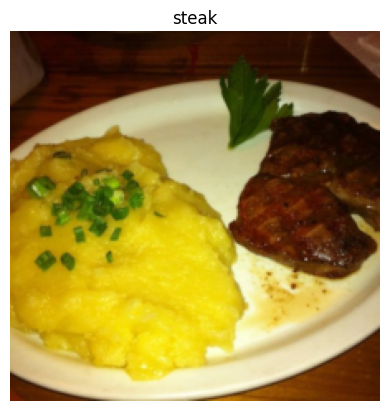

In [7]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## Replicating ViT: overview

## Split data into patches and creating a class, position and patch embadding

layers=>input=>function=>output

In [8]:
height =224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches 
number_of_pathces = int((height * width) / patch_size**2)
number_of_pathces

196

In [9]:
embedding_layer = (height, width, color_channels)

embedding_layer_output_shape = (number_of_pathces, patch_size**2 * color_channels)

print(f'input shape (single 2D image): {embedding_layer}')
print(f'output shape (1D sequence of images): {embedding_layer_output_shape}')

input shape (single 2D image): (224, 224, 3)
output shape (1D sequence of images): (196, 768)


## Turning a single image into pathces

In [10]:
image.shape

torch.Size([3, 224, 224])

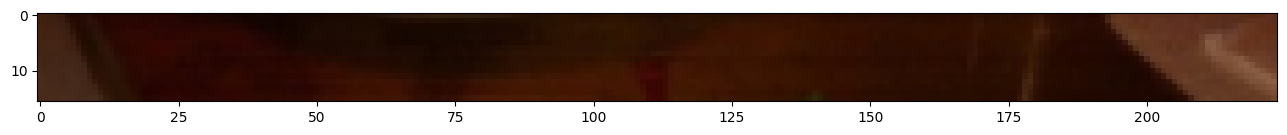

In [11]:
image_permuted = image.permute(1,2,0)

# index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


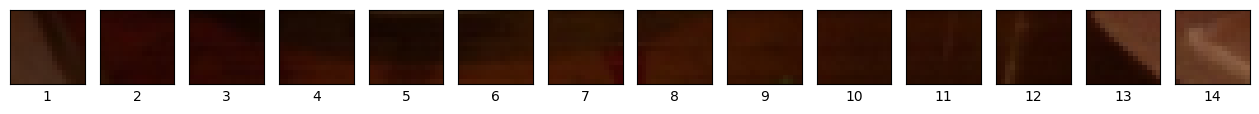

In [12]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'Image size must be divisable by patch size'
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of pathces in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

number of pathes per row: 14.0
Number of patches per column: 14.0
Total pathces: 196.0
Patch size: 16 pixels x 16 pixels


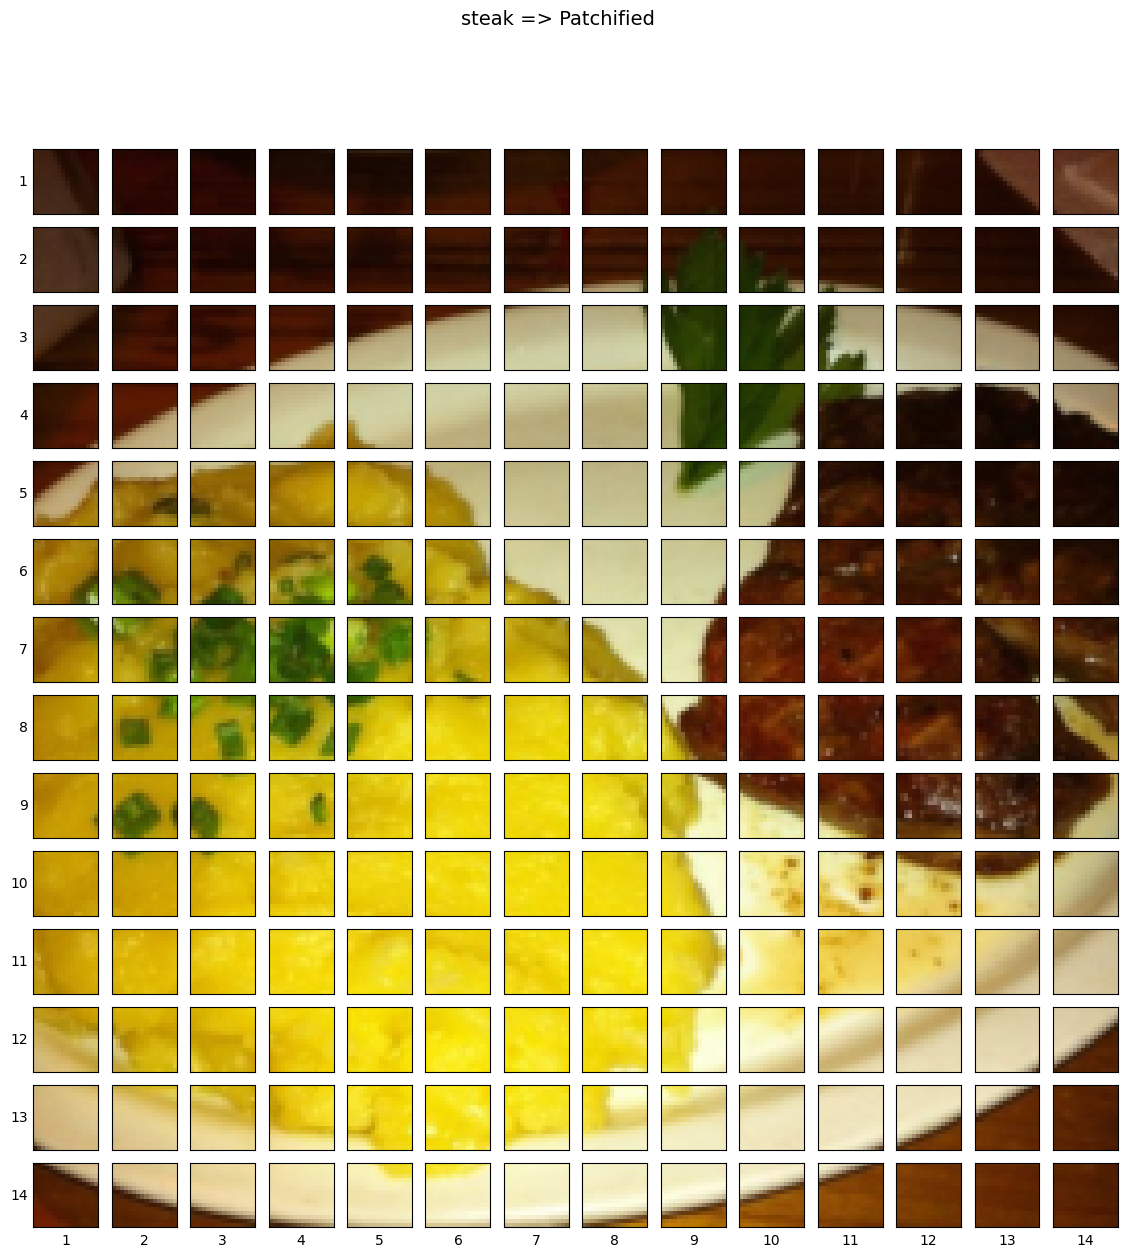

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'image size must be divisable by patch size'
print(f'number of pathes per row: {num_patches}\nNumber of patches per column: {num_patches}\nTotal pathces: {num_patches*num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a seriese of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(num_patches, num_patches))

for i, patch_height in enumerate(range(0,img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                        patch_width:patch_width+patch_size,
                        :])
        # Set up label info for each subplot
        axs[i,j].set_ylabel(i+1,
                            rotation='horizontal',
                            horizontalalignment='right',
                            verticalalignment='center')
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

fig.suptitle(f'{class_names[label]} => Patchified', fontsize=14)
plt.show()

## Creating image patches and turning them into patch embaddings

In [14]:
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

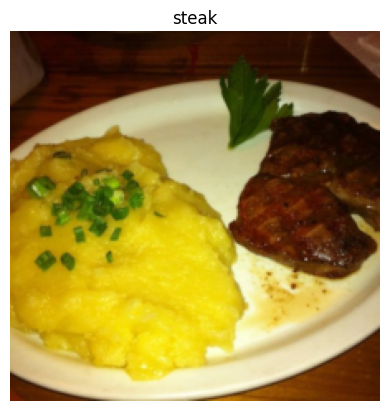

In [15]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [16]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [17]:
image_out_of_conv.requires_grad

True

showing random convolutional feature maps from indexes: [694, 547, 330, 258, 264]


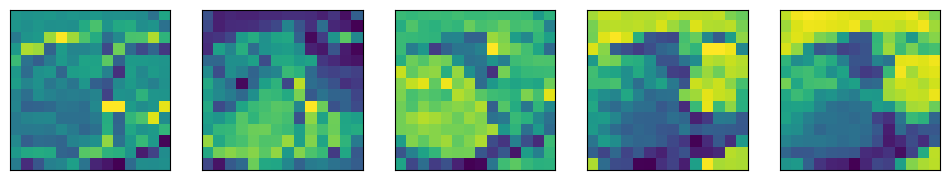

In [18]:
# plot random convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f'showing random convolutional feature maps from indexes: {random_indexes}')

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :,:]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [19]:
single_image_map = image_out_of_conv[:,0,:,:]
single_image_map, single_image_map.requires_grad

(tensor([[[ 0.1020,  0.0697,  0.0881,  0.0920,  0.0961,  0.1058,  0.1208,
            0.1033,  0.0892,  0.0752,  0.0541,  0.0837, -0.0643,  0.0444],
          [ 0.0766,  0.0969,  0.0872,  0.0795,  0.0874,  0.0860,  0.1012,
            0.1735,  0.0564,  0.0628,  0.1150,  0.0947,  0.0734, -0.0253],
          [ 0.0856,  0.1041,  0.0978,  0.1019,  0.1583, -0.0586, -0.0644,
           -0.0188,  0.2439,  0.0654, -0.2415,  0.0135,  0.1407,  0.2444],
          [ 0.0774,  0.0560, -0.0420, -0.0084, -0.0676, -0.0128, -0.0146,
            0.0117,  0.2956,  0.0892,  0.0571,  0.1204,  0.0174, -0.2705],
          [ 0.0737,  0.2021,  0.2176,  0.2495,  0.3433,  0.1096, -0.0081,
           -0.0184,  0.1699,  0.0544,  0.1577,  0.1155,  0.0651,  0.0553],
          [ 0.2719,  0.0506,  0.1862,  0.2159,  0.1760,  0.3167, -0.0143,
           -0.0175, -0.0567,  0.1990,  0.1706,  0.0799,  0.1649,  0.1357],
          [ 0.3115,  0.2839,  0.1689,  0.1056,  0.1905,  0.2351,  0.4054,
            0.0243,  0.1492,  0.

## Flattening patch embaddings

In [20]:
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

original image shape: torch.Size([3, 224, 224])
Image feature map (pathces) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: tensor([[[ 0.1020,  0.0697,  0.0881,  ...,  0.2013,  0.1797,  0.1604],
         [-0.1393, -0.1266, -0.0888,  ..., -0.3290, -0.2760, -0.2359],
         [-0.0707, -0.0924, -0.0852,  ..., -0.1887, -0.1713, -0.1540],
         ...,
         [-0.0502, -0.0198, -0.0086,  ..., -0.1643, -0.1138, -0.0823],
         [-0.0783, -0.0081, -0.0042,  ..., -0.0449, -0.0351, -0.0248],
         [-0.0339, -0.0377, -0.0340,  ..., -0.0644, -0.0633, -0.0610]]],
       grad_fn=<ViewBackward0>)


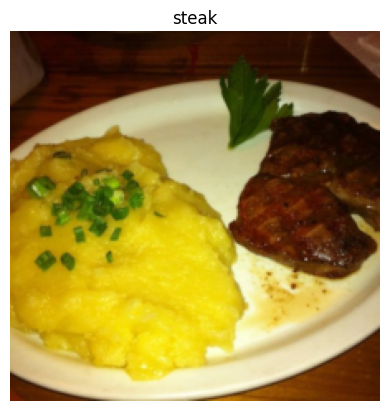

In [21]:
# Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'original image shape: {image.shape}')

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'Image feature map (pathces) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened}')

In [24]:
# rearrange output of flatten layer
print(f'{image_out_of_conv_flattened.permute(0,2,1).shape}')

torch.Size([1, 196, 768])


In [28]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)

In [29]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map

tensor([[ 0.1020,  0.0697,  0.0881,  0.0920,  0.0961,  0.1058,  0.1208,  0.1033,
          0.0892,  0.0752,  0.0541,  0.0837, -0.0643,  0.0444,  0.0766,  0.0969,
          0.0872,  0.0795,  0.0874,  0.0860,  0.1012,  0.1735,  0.0564,  0.0628,
          0.1150,  0.0947,  0.0734, -0.0253,  0.0856,  0.1041,  0.0978,  0.1019,
          0.1583, -0.0586, -0.0644, -0.0188,  0.2439,  0.0654, -0.2415,  0.0135,
          0.1407,  0.2444,  0.0774,  0.0560, -0.0420, -0.0084, -0.0676, -0.0128,
         -0.0146,  0.0117,  0.2956,  0.0892,  0.0571,  0.1204,  0.0174, -0.2705,
          0.0737,  0.2021,  0.2176,  0.2495,  0.3433,  0.1096, -0.0081, -0.0184,
          0.1699,  0.0544,  0.1577,  0.1155,  0.0651,  0.0553,  0.2719,  0.0506,
          0.1862,  0.2159,  0.1760,  0.3167, -0.0143, -0.0175, -0.0567,  0.1990,
          0.1706,  0.0799,  0.1649,  0.1357,  0.3115,  0.2839,  0.1689,  0.1056,
          0.1905,  0.2351,  0.4054,  0.0243,  0.1492,  0.1913,  0.1699,  0.1585,
          0.0351,  0.0914,  

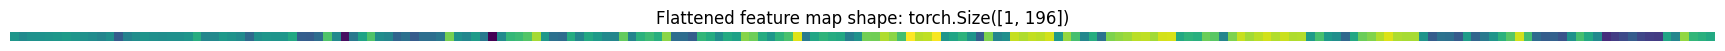

In [30]:
# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False);

## Turning the ViT patch embedding layer into a PyTorch module

In [32]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f'Input image size must be divisable by patch size, image shape: {image_resolution}, patch size: {self.patch_size}'

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0,2,1)

In [35]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f'Input image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0))
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])
